In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
MNIST_train.targets.shape

torch.Size([60000])

In [5]:
MNIST_train.data.shape #в трейне 60к изображений 28х28

torch.Size([60000, 28, 28])

In [6]:
MNIST_test.data.shape # в тесте 10к изображений 28х28

torch.Size([10000, 28, 28])

In [7]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

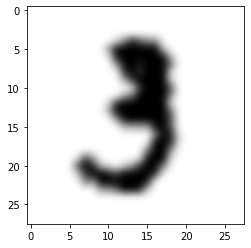

tensor(3)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10, :, :], cmap='binary', interpolation='bicubic')
plt.show()
print(y_train[10])

In [9]:
X_train = X_train.unsqueeze(1).float() #добавляем измерение канала изображения (в нашем случае =1, т.к. черно-белое изображение)
X_test = X_test.unsqueeze(1).float()

In [10]:
X_train[0].shape

torch.Size([1, 28, 28])

In [11]:
from torch import nn
from torch.functional import F

In [17]:
class LeNet2(nn.Module):
  def __init__(self, 
               activation = 'tanh', 
               pooling = 'avg',
               conv_size=5,
               batch_norm=False):
    super(LeNet2, self).__init__()

    self.activation = activation
    self.pooling = pooling
    self.conv_size = conv_size
    self.batch_norm = batch_norm

    if activation == 'tanh':
      act_f = nn.Tanh()
    elif activation == 'relu':
      act_f = nn.ReLU()
    else:
      raise NotImplementedError

    if pooling == 'avg':
      pool_layer = nn.AvgPool2d(kernel_size=2, stride=2)
    elif pooling =='max':
      pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
    else:
      raise NotImplementedError

    #input = (размер батча,1,28,28)
    if conv_size == 5:
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2) 
      #(размер батча,6,28,28)
    elif conv_size==3:
      self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
      self.conv1_2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
    else:
      raise NotImplementedError

    self.act1 = act_f
    self.bn1 = nn.BatchNorm2d(num_features=6)
    self.pool1 = pool_layer
    
    #(размер батча,6,14,14)
    if conv_size == 5:
      self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
    elif conv_size==3:
      self.conv2_1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
      self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
    else:
      raise NotImplementedError
    #(размер батча,16,10,10)

    self.act2 = act_f
    self.bn2 = nn.BatchNorm2d(num_features=16)
    self.pool2 = pool_layer
    #(размер батча,16,5,5)


    # #(размер батча,120,1,1)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120, bias=True)
    self.act3 = act_f
    self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
    self.act4=act_f
    #(размер батча,84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    if self.conv_size==5:
      x = self.conv1(x)
    elif self.conv_size==3:
      x = self.conv1_2(self.conv1_1(x))
    x = self.act1(x) 
    if self.batch_norm:
      x = self.bn1(x)
    x = self.pool1(x)
    
    if self.conv_size==5:
      x = self.conv2(x)
    elif self.conv_size==3:
      x = self.conv2_2(self.conv2_1(x))
    x = self.act2(x) 
    if self.batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)

    return self.fc3(x)


In [18]:
LeNet2().forward(X_train[:20])[0] #результат работы для одной картинки

tensor([-0.0537, -0.0498, -0.0807,  0.0489, -0.1405,  0.1165,  0.1854, -0.1488,
        -0.0374, -0.1155], grad_fn=<SelectBackward>)

In [32]:
def train_nn(net, dataloader, X_test, y_test, epochs=100):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=net.parameters())

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  test_loss = []
  test_accuracy = []

  for epoch in range(epochs):
    for train_batch, train_label in dataloader:
      optimizer.zero_grad()
      net.train()
      train_batch, train_label = train_batch.to(device), train_label.to(device)

      preds = net.forward(train_batch)
      loss = criterion(preds, train_label)
      loss.backward()
      optimizer.step()

    net.eval()
    test_preds = net.forward(X_test)
    t_loss = criterion(test_preds, y_test)
    t_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()

    test_loss.append(t_loss.data.cpu())
    test_accuracy.append(t_accuracy.data.cpu())

    if epoch % 5 ==0:
      print(f'Epoch: {epoch}, accuracy: {t_accuracy}')
      print('***')

  return test_loss, test_accuracy





In [33]:
partition = {'train':[]}
labels = {}

for idx, p in enumerate(X_train):

  partition['train'].append(idx)
  labels[idx] = y_train[idx]

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
    self.list_IDs = list_IDs
    self.labels = labels

  def __len__(self):
    return len(self.list_IDs)

  def __getitem__(self, idx):
    ID = self.list_IDs[idx]
    
    X = X_train[ID] #загружаем данные - в другом варианте мы могли бы загружать их с диска
    y = self.labels[ID]
    
    return X, y


params = {'batch_size':100,
          'shuffle':True, 
          'num_workers':4}

train_iter = torch.utils.data.DataLoader(MyDataset(partition['train'], labels), **params)
# valid_iter = torch.utils.data.DataLoader(MyDataset(partition['valid'], labels), **params)


In [ ]:
#одна выгрузка даталоадера
print(next(iter(train_iter))[0].shape) # (размер батча, кол-во каналов, ширина, высота)
print(next(iter(train_iter))[1].shape) # метки таргета по размеру батча

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [34]:
%%time
import warnings
warnings.filterwarnings('ignore')


accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train_nn(LeNet2(activation='tanh', conv_size=5),
          train_iter, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train_nn(LeNet2(activation='relu', conv_size=5),
          train_iter, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train_nn(LeNet2(activation='relu', conv_size=3),
         train_iter, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train_nn(LeNet2(activation='relu', conv_size=3, pooling='max'), 
          train_iter, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train_nn(LeNet2(activation='relu', conv_size=3, pooling='max', batch_norm=True), 
          train_iter, X_test, y_test)

Epoch: 0, accuracy: 0.9767999649047852
***
Epoch: 5, accuracy: 0.988599956035614
***
Epoch: 10, accuracy: 0.9886999726295471
***
Epoch: 15, accuracy: 0.988099992275238
***
Epoch: 20, accuracy: 0.9882999658584595
***
Epoch: 25, accuracy: 0.9896999597549438
***
Epoch: 30, accuracy: 0.9884999990463257
***
Epoch: 35, accuracy: 0.988099992275238
***
Epoch: 40, accuracy: 0.9871999621391296
***
Epoch: 45, accuracy: 0.9892999529838562
***
Epoch: 50, accuracy: 0.9881999492645264
***
Epoch: 55, accuracy: 0.9874999523162842
***
Epoch: 60, accuracy: 0.9869999885559082
***
Epoch: 65, accuracy: 0.9888999462127686
***
Epoch: 70, accuracy: 0.9878999590873718
***
Epoch: 75, accuracy: 0.9878000020980835
***
Epoch: 80, accuracy: 0.9881999492645264
***
Epoch: 85, accuracy: 0.9870999455451965
***
Epoch: 90, accuracy: 0.988099992275238
***
Epoch: 95, accuracy: 0.9896000027656555
***
Epoch: 0, accuracy: 0.9800999760627747
***
Epoch: 5, accuracy: 0.9893999695777893
***
Epoch: 10, accuracy: 0.9882999658584595


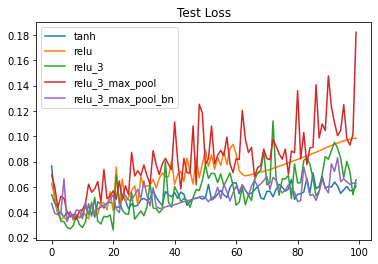

In [37]:
for experiment in accuracies.keys():
  plt.plot(accuracies[experiment], label=experiment)
plt.legend()
plt.title('Test Loss')
plt.show()

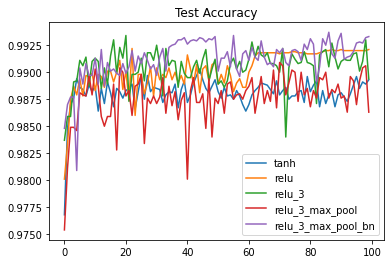

In [38]:
for experiment in losses.keys():
  plt.plot(losses[experiment], label=experiment)
plt.legend()
plt.title('Test Accuracy')
plt.show()